In [2]:
%reload_ext autoreload
%autoreload 2
import os, sys
if 'notebook_path' not in vars():
    notebook_path = os.getcwd()
os.chdir(os.path.join(notebook_path,".."))
sys.path.append(os.getcwd())

import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py
from scipy.io import wavfile
from glob import glob
import importlib
import json

In [3]:

dataset_path = "./data/reference_data/tdoa_20201016/data/"
experiment = "music_0014"


n_audio_files = len(glob(os.path.join(dataset_path,experiment,"*.wav")))

sounds = []
for i in range(n_audio_files):
    fs, temp = wavfile.read(os.path.join(dataset_path,experiment,"Track " + str(i+1) + ".wav"))
    sounds.append(temp)
sounds = np.stack(sounds)

#read gt
df = pd.read_csv(os.path.join(dataset_path, experiment, "gt_positions.csv")) # Note time-column = 0 when audio-recordings started

dims = ["x","y","z"]
time = df["time"]
senders = df[["speaker" + "_" +dim for dim in dims]].to_numpy()
receivers = np.zeros((n_audio_files,3))
for i in range(n_audio_files):
    for j,dim in enumerate(["x","y","z"]):
        temp = df["mic" + str(i+1) + "_" + dim]
        receivers[i,j] = temp[temp.notnull()].median()

#settings
downsampling_factor = 6 # going from 96 kHz to 16 kHz which models are trained on
chunk_length = 10000
max_freq = 2500 #component of fft, NOT in HZ

#constants
n_chunks = (sounds.shape[1]//downsampling_factor) // (chunk_length)
n_mics = sounds.shape[0]
n_pairs = n_mics*(n_mics-1)//2
speed_of_sound = 343
max_diff_meters = chunk_length*speed_of_sound/(2*fs)

# divide sound into chunks
chunks = sounds[:,::downsampling_factor][:,:n_chunks*chunk_length].reshape(n_mics, n_chunks, chunk_length)
chunk_times = np.array([downsampling_factor*chunk_length/fs*i for i in range(n_chunks)])

# time sync ground truth to chunks
sender_position_at_chunk = np.stack([np.interp(chunk_times,time,senders[:,i]) for i in range(3)]).T

# create all pairs
pairs = np.zeros(((chunks.shape[0]*(chunks.shape[0]-1))//2, chunks.shape[1], 4 ,max_freq))
pairs_gt = np.zeros(((chunks.shape[0]*(chunks.shape[0]-1))//2, chunks.shape[1]))
counter = 0
for mic1 in range(12):
    for mic2 in range(mic1+1,12):
        pairs[counter,:,0] = np.real(sp.fft.rfft(chunks[mic1])[:,:max_freq])
        pairs[counter,:,1] = np.real(sp.fft.rfft(chunks[mic2])[:,:max_freq])
        pairs[counter,:,2] = np.imag(sp.fft.rfft(chunks[mic1])[:,:max_freq])
        pairs[counter,:,3] = np.imag(sp.fft.rfft(chunks[mic2])[:,:max_freq])
        

        pairs_gt[counter] = (np.linalg.norm(sender_position_at_chunk - receivers[mic1],axis=1) - np.linalg.norm(sender_position_at_chunk - receivers[mic2],axis=1))
        counter += 1 

# Load your model as variable name "model" in Cell bellow

In [4]:
from src.cnn_model import cnn_model

model = cnn_model.load_from_checkpoint("lightning_logs/d4owgr31/checkpoints/epoch=999-step=76000.ckpt", scale_model_width=2, map_location=torch.device("cpu") )

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
# Settings --------------------------------------
dataset_path = "../data/datasets/impulse_response_medium_evaluation.hdf5"

# model_folder = "../runs/astral-shadow-62/"
# checkpoint = "new_type_dataset_medium_astral-shadow-62_900.pth" #False

# model_folder = "../runs/gallant-waterfall-89/"
# checkpoint = "cnn_model_partly_trained.ckpt"

#batch_size = 100 # just needed to make computation smooth
#device = "cpu"#'cuda:1' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
#-------------------------------------------------


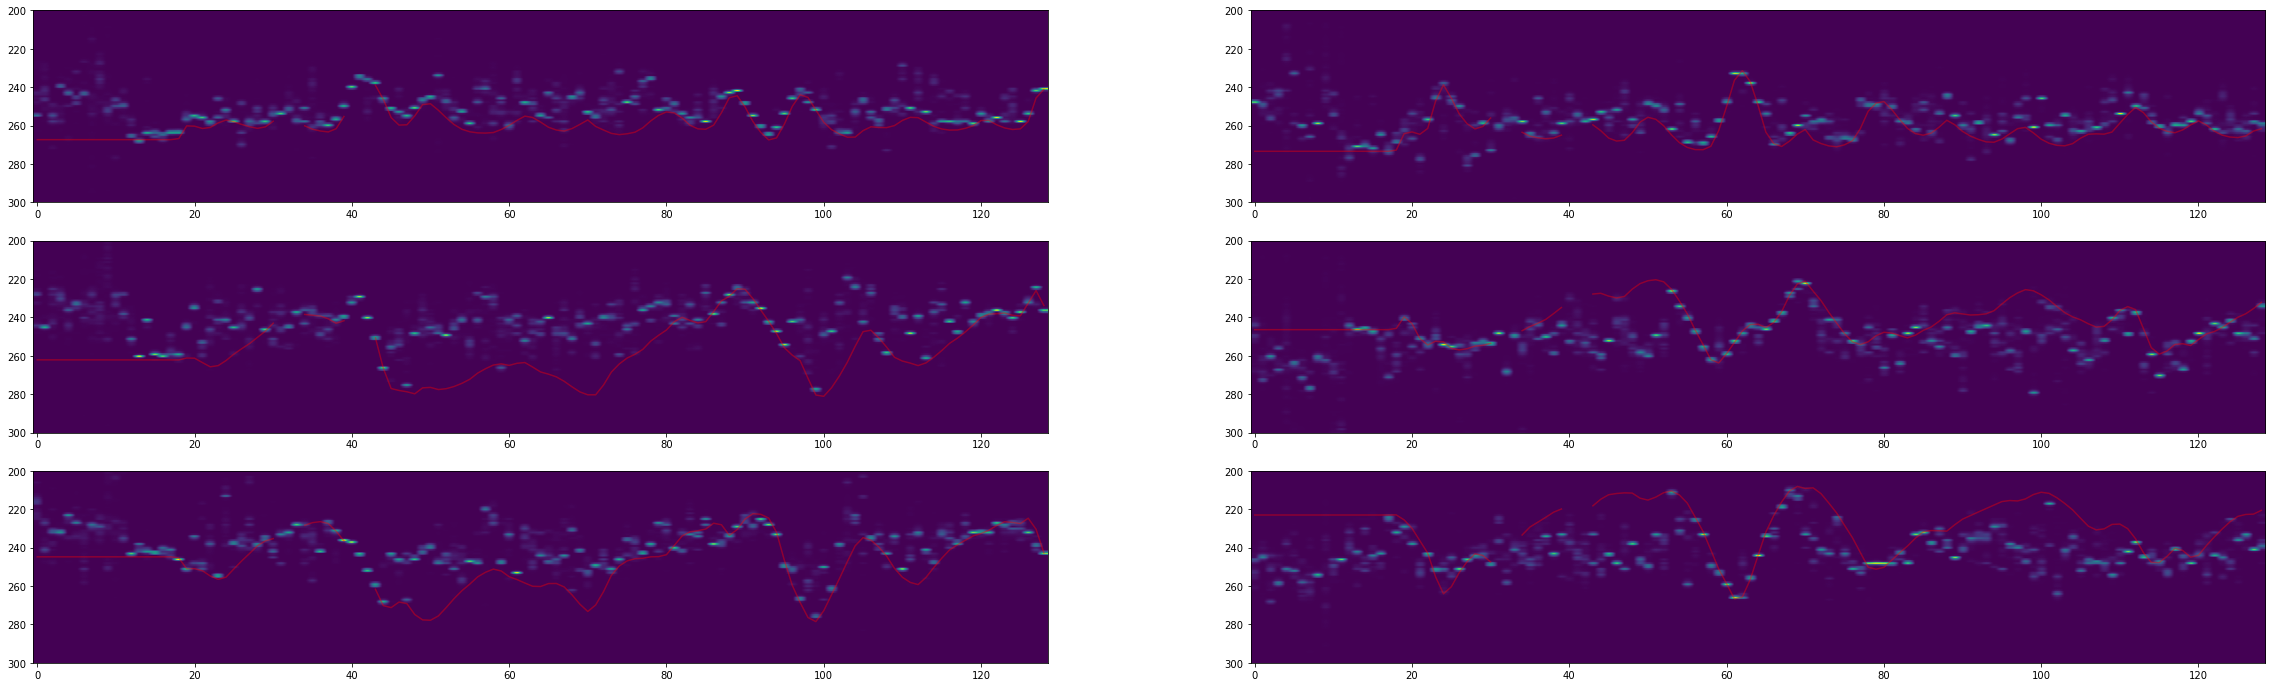

In [58]:
#mic1 = 0
#mic2 = 1
plots = [[0,1,11],[60,57,56]]

f, ax = plt.subplots(3,len(plots),figsize=(40,12))
for i in range(len(plots)):
        for ii,pair_i in enumerate(plots[i]):
                X = torch.tensor(pairs[pair_i],dtype=torch.float)
                #X -= X.mean(dim=(1,2), keepdim=True)
                #X = X/4e4
                #X[:,:,:50] = 0
                pred = model(X)
                def y_to_class_gt(y, guess_grid_size, max_shift) :
                        y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

                        bin_width = max_shift*2/guess_grid_size
                        y = (y/bin_width).round() + guess_grid_size // 2 
                        y[y == guess_grid_size] = guess_grid_size - 1
                        return y.long()

                y = y_to_class_gt(torch.tensor(pairs_gt[pair_i]*16000/343), 500, 500)
                #
                #plt.figure(figsize=(10,3))
                
                ax[ii][i].plot(torch.tensor(pairs_gt[pair_i]*16000/343)/2 + 250,'r-', alpha=0.4)
                #plt.imshow((pred.softmax(dim=1).detach().cpu() + 0.001).log().T, aspect='auto')
                ax[ii][i].imshow(pred.softmax(dim=1).detach().cpu().T, aspect='auto')
                ax[ii][i].set_ylim(300,200)
                #f.ylim(350,150)
                #ax[ii][i].set_title(pair_i)

        #f.title(pair_i)
        


In [ ]:
0,1,11,60,57,56,65

7


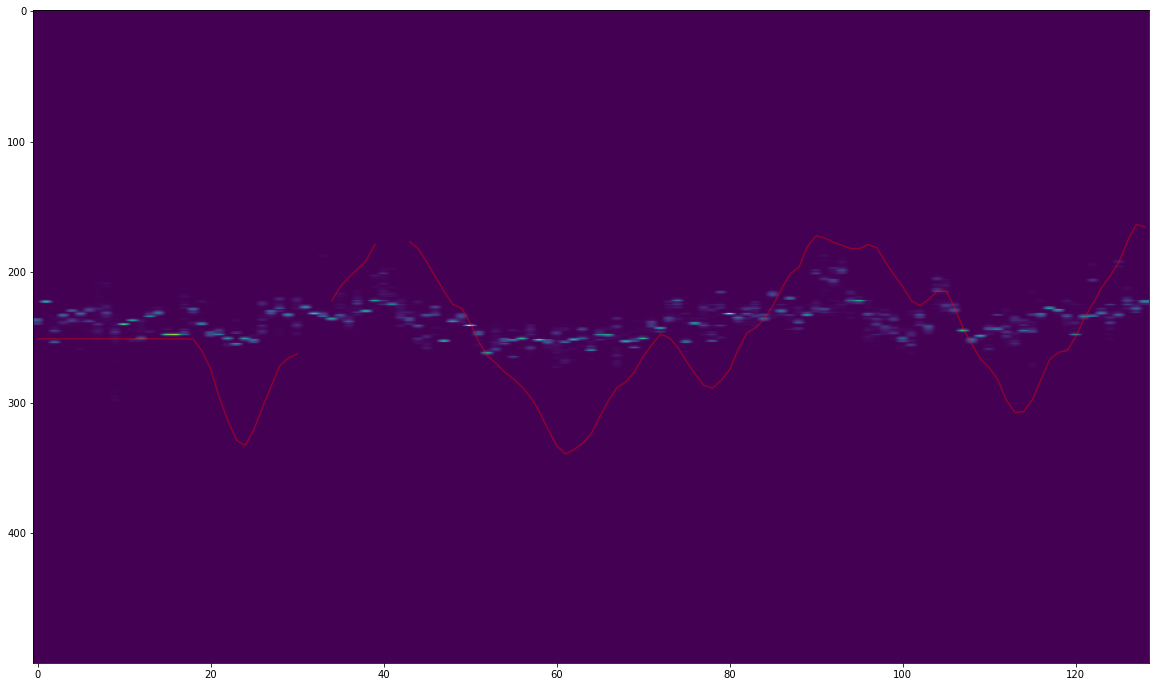

In [57]:
#pair_i = 12
m1 = 0
m2 = 8
pair_i = 0
fin = False
for i in range(12):
    if fin:
        break
    for j in range(i+1,12):
        if i == m1 and j == m2:
            fin = True
            break
        pair_i += 1
print(pair_i)
X = torch.tensor(pairs[pair_i],dtype=torch.float)
pred = model(X)
plt.figure(figsize=(20,12))
plt.plot(torch.tensor(pairs_gt[pair_i]*16000/343)/2 + 249,'r-', alpha=0.4)
#plt.imshow((pred.softmax(dim=1).detach().cpu() + 0.001).log().T, aspect='auto')
plt.imshow(pred.softmax(dim=1).detach().cpu().T, aspect='auto')